## Problem Statement:

### How good is player X against MI in Wankhede when they’re playing 3 spinners?

- (Apart from career statistics (matches/runs/avg/sr) What information can be derived from a player’s historic data?)
- Strengths & Weaknesses against bowling types
- His contribution to team’s win
- Performance against specific opposition
- Performance in specific venues


### Topics Involved:
- Player Analysis
    - Player-level statistics --- (runs/sr/RPI/BPB)
    - Type of player --- (anchor/strike-rotator/hitter)
    - Performance in diff phases of play --- (PP/Middle/Death)
    - Performance by innings --- (Bat 1st/2nd)
- Team Analysis
    - Performance against oppositions --- (RPI/SR)
- Venue Analysis
    - Performance in venues
    - Toss factor
    - Venue type --- (runrates, wickets, ..)

In [1]:
import math
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

import matplotlib.pyplot as plt

In [2]:
deliveries = pd.read_csv('deliveries.csv')
matches = pd.read_csv('matches.csv')

In [3]:
deliveries.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


In [4]:
matches.head(2)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN


## Part 1: Player Statistics

### 1.1 : Extract player-level statistics
### 1.2 : Determine player type from the above stats

In [5]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1 
    
def balls_per_boundary(balls, boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1 

def playerStatistics(df):
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [6]:
df = playerStatistics(deliveries)

In [7]:
df.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,23,280,196,15,61,83,20,1,16,15,142.857143,12.173913,13.066667,6.322581
1,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.000000
2,A Chopra,6,53,75,5,45,21,2,0,7,0,70.666667,8.833333,15.000000,10.714286
3,A Choudhary,3,25,20,2,4,13,1,0,1,1,125.000000,8.333333,10.000000,10.000000
4,A Flintoff,3,62,57,2,24,23,2,1,5,2,108.771930,20.666667,28.500000,8.142857


### 1.3 : Performance in different phases of play

In [8]:
def phase(over):
    if over <= 6:
        return 'Powerplay'
    elif over <= 15:
        return 'Middle'
    else:
        return 'Death'

In [9]:
deliveries['phase'] = deliveries['over'].apply(lambda x: phase(x))

In [10]:
def phasesOfplay(df, current_phase):
    
    df = df[df.phase == current_phase]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [11]:
pp_df = phasesOfplay(deliveries, 'Powerplay')
mid_df = phasesOfplay(deliveries, 'Middle')
dth_df = phasesOfplay(deliveries, 'Death')

In [12]:
pp_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,1,5,7,1,5,1,0,0,1,0,71.428571,5.0,7.0,7.00
1,A Chopra,5,27,41,2,26,11,0,0,4,0,65.853659,5.4,20.5,10.25


In [13]:
mid_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,5,61,41,0,16,13,5,0,2,5,148.780488,12.200000,41.0,5.857143
1,A Chopra,3,25,32,2,18,9,2,0,3,0,78.125000,8.333333,16.0,10.666667


In [14]:
dth_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,22,214,148,14,40,69,15,1,13,10,144.594595,9.727273,10.571429,6.434783
1,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.000000


### 1.4 : Performance by Bat 1st/2nd

In [15]:
def ByInning(df, current_inning):
    
    df = df[df.inning == current_inning]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [16]:
ing1_df = ByInning(deliveries, 1)
ing2_df = ByInning(deliveries, 2)

In [17]:
ing1_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,13,166,115,7,32,53,13,1,6,10,144.347826,12.769231,16.428571,7.1875
1,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.0000


In [18]:
ing2_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,10,114,81,8,29,30,7,0,10,5,140.740741,11.4,10.125,5.4
1,A Chopra,1,2,3,1,1,2,0,0,0,0,66.666667,2.0,3.000,3.0


In [19]:
comp = ing1_df[['batsman', 'RPI']].merge(ing2_df[['batsman', 'RPI']], on = 'batsman', how = 'inner').rename(columns = {'RPI_x':'1st_RPI', 'RPI_y':'2nd_RPI' })

In [20]:
comp.head(2)

,batsman,1st_RPI,2nd_RPI
0,A Ashish Reddy,12.769231,11.4
1,A Chopra,10.200000,2.0


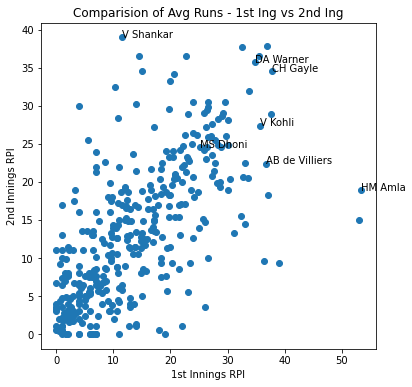

In [21]:
plt.figure(figsize = (6, 6))
plt.scatter(comp['1st_RPI'], comp['2nd_RPI'] )
plt.xlabel('1st Innings RPI')
plt.ylabel('2nd Innings RPI')
plt.title('Comparision of Avg Runs - 1st Ing vs 2nd Ing')

annotations=list(comp['batsman'])
selected_players = ['CH Gayle', 'V Kohli', 'AB de Villiers', 'DA Warner', 'V Shankar', 'HM Amla', 'MS Dhoni']

for i, label in enumerate(annotations):
    if label in selected_players:
        plt.annotate(label, (comp['1st_RPI'][i], comp['2nd_RPI'][i]))
    
    
plt.show()

In [22]:
comp[comp['1st_RPI'] > 50]

,batsman,1st_RPI,2nd_RPI
119,HM Amla,53.25,18.875
168,Kamran Akmal,53.00,15.000


## Part 2 - Performance by opposition:

In [23]:
def ByOpposition(df, current_opposition):
    
    df = df[df.bowling_team == current_opposition]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    # StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    # runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    # balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [24]:
ByOpposition(deliveries, 'Royal Challengers Bangalore').head(3)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,5,55,42,4,15,19,2,0,2,4,130.952381,11.0,10.5,7.0
1,A Chandila,1,4,6,0,2,4,0,0,0,0,66.666667,4.0,6.0,6.0
2,A Chopra,1,2,5,1,3,2,0,0,0,0,40.000000,2.0,5.0,5.0


In [25]:
deliveries.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,isDot,isOne,isTwo,isThree,isFour,isSix,phase
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,0,0,0,0,0,Powerplay
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,0,0,0,0,0,Powerplay


## Kohli's performance against all teams:

In [26]:
selected_player = 'V Kohli'

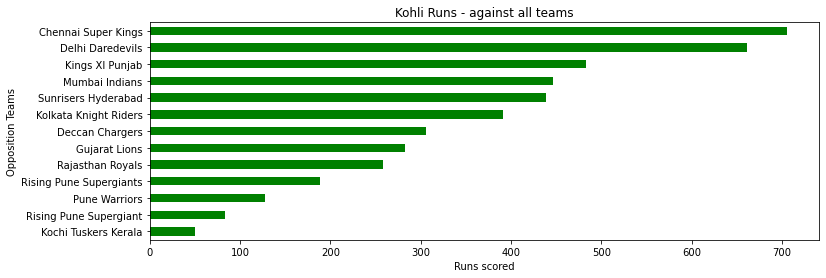

In [27]:
plt.figure(figsize = (12, 4))
deliveries[deliveries.batsman == selected_player].groupby(['bowling_team'])['batsman_runs'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('Kohli Runs - against all teams')
plt.xlabel('Runs scored')
plt.ylabel('Opposition Teams')
plt.show()

## Part 3 : Venue Analysis

In [28]:
def wintoss_winmatch(toss_decision, team1, team2, winner):
    if toss_decision == 'field':
        if team2 == winner:
            return True
        else:
            return False
        
    else:
        if team1 == winner:
            return True
        else:
            return False


In [29]:
matches['wintoss_winmatch'] = matches.apply(lambda x: wintoss_winmatch(x['toss_decision'], x['team1'], x['team2'], x['winner']), axis = 1)

In [30]:
matches[['id', 'season', 'team1', 'team2', 'wintoss_winmatch']].head()

,id,season,team1,team2,wintoss_winmatch
0,1,2017,Sunrisers Hyderabad,Royal Challengers Bangalore,False
1,2,2017,Mumbai Indians,Rising Pune Supergiant,True
2,3,2017,Gujarat Lions,Kolkata Knight Riders,True
3,4,2017,Rising Pune Supergiant,Kings XI Punjab,True
4,5,2017,Royal Challengers Bangalore,Delhi Daredevils,True


In [31]:
print('% of wintoss-winmatch =', 100*len(matches[matches.wintoss_winmatch == 1])/len(matches))

% of wintoss-winmatch = 51.100628930817614


In [32]:
def isOut(player_dismissed):
    try:
        x = math.isnan(player_dismissed)
        return 0
    except:
        return 1

def venueAnalysis(mdf, df):
    
    runs = pd.DataFrame(df.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index())
    runs['Id_Ing'] = runs.apply(lambda x: str(x['match_id']) + '-' + str(x['inning']), axis = 1)
    
    balls = pd.DataFrame(df.groupby(['match_id', 'inning'])['total_runs'].count().reset_index()).rename(columns = {'total_runs':'total_balls'})
    balls['Id_Ing'] = balls.apply(lambda x: str(x['match_id']) + '-' + str(x['inning']), axis = 1)
    
    df['isOut'] = df['player_dismissed'].apply(lambda x: isOut(x))
    outs = pd.DataFrame(df.groupby(['match_id', 'inning'])['isOut'].sum().reset_index()).rename(columns = {'isOut':'wickets'})
    outs['Id_Ing'] = outs.apply(lambda x: str(x['match_id']) + '-' + str(x['inning']), axis = 1)
    
    df = pd.merge(runs, balls[['Id_Ing', 'total_balls']], on = 'Id_Ing').merge(outs[['Id_Ing', 'wickets']], on = 'Id_Ing')
    
    mdf = mdf.rename(columns = {'id':'match_id'})
    df = pd.merge(df, mdf[['match_id', 'venue']], on = 'match_id')
    df = df[['match_id', 'venue', 'inning', 'total_runs', 'total_balls', 'wickets']]
    
    return df

In [33]:
ven_df = venueAnalysis(matches, deliveries)

In [34]:
ven_df.head()

,match_id,venue,inning,total_runs,total_balls,wickets
0,1,"Rajiv Gandhi International Stadium, Uppal",1,207,125,4
1,1,"Rajiv Gandhi International Stadium, Uppal",2,172,123,10
2,2,Maharashtra Cricket Association Stadium,1,184,125,8
3,2,Maharashtra Cricket Association Stadium,2,187,122,3
4,3,Saurashtra Cricket Association Stadium,1,183,122,4


In [35]:
pd.DataFrame(ven_df.groupby('venue')['total_runs'].mean().sort_values(ascending = False)).rename(columns = {'total_runs':'Avg_Runs'}).reset_index().head(10)

,venue,Avg_Runs
0,Brabourne Stadium,174.636364
1,Barabati Stadium,162.714286
2,Green Park,162.250000
3,"Punjab Cricket Association IS Bindra Stadium, Mohali",161.136364
4,Himachal Pradesh Cricket Association Stadium,160.944444
5,Maharashtra Cricket Association Stadium,158.733333
6,Wankhede Stadium,157.815789
7,Holkar Cricket Stadium,157.600000
8,"Punjab Cricket Association Stadium, Mohali",156.957143
9,"MA Chidambaram Stadium, Chepauk",155.887755


In [36]:
def ByVenue(df, current_venue):
    
    df = df[df.venue == current_venue]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [37]:
matches.rename(columns = {'id':'match_id'}, inplace = True)

In [38]:
combined_data = deliveries.merge(matches[['match_id', 'venue']], on = 'match_id', how = 'left')

In [39]:
combined_data.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,isDot,isOne,isTwo,isThree,isFour,isSix,phase,isOut,venue
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,0,0,0,0,0,Powerplay,0,"Rajiv Gandhi International Stadium, Uppal"
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,0,0,0,0,0,Powerplay,0,"Rajiv Gandhi International Stadium, Uppal"


In [40]:
current_venue = 'Wankhede Stadium'

In [41]:
df = ByVenue(combined_data, current_venue)

In [42]:
df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,1,10,10,1,6,2,1,0,0,1,100.0,10.0,10.0,10.0
1,A Chopra,1,1,4,0,3,1,0,0,0,0,25.0,1.0,4.0,4.0


### Problem Statement: How good is player X against MI in Wankhede when they’re playing 3 spinners?

### Filters in our problem statement:
- Stadium = 'Wankhede Stadium'
- Phase = 'Middle Overs'
- Oppostion Team = 'Mumbai Indians'

In [43]:
def ByCustom(df, current_venue, current_phase, current_opposition):
    
    df = df[df.venue == current_venue]
    df = df[df.phase == current_phase]
    df = df[df.bowling_team == current_opposition]
    
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [44]:
df = ByCustom(combined_data, 'Wankhede Stadium', 'Middle', 'Mumbai Indians')

In [45]:
df['dot_percentage'] = df.apply(lambda x: x['dots']/x['balls'], axis = 1)

In [46]:
df.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB,dot_percentage
0,A Ashish Reddy,1,10,8,0,4,2,1,0,0,1,125.000000,10.0,8.00,8.000000,0.500000
1,AB Agarkar,1,15,14,1,6,5,1,0,2,0,107.142857,15.0,14.00,7.000000,0.428571
2,AB Dinda,1,1,1,0,0,1,0,0,0,0,100.000000,1.0,1.00,1.000000,0.000000
3,AB de Villiers,5,134,79,4,21,32,5,0,17,4,169.620253,26.8,19.75,3.761905,0.265823
4,AD Mathews,2,24,25,1,8,14,2,0,0,1,96.000000,12.0,25.00,25.000000,0.320000


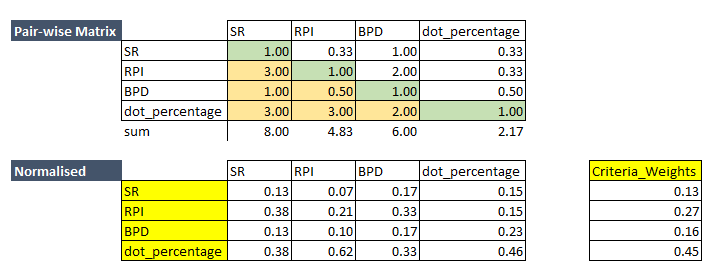

In [47]:
wt_sr, wt_rpi, wt_bpd, wt_dot_percentage = 0.13, 0.27, 0.16, 0.45

In [48]:
df = df[df.innings >= 2 ]

### Calculation - Normalizing all values to same dimensions

In [49]:
#step1: square of all values
df['calc_SR'] = df['SR'].apply(lambda x: x*x) 
df['calc_RPI'] = df['RPI'].apply(lambda x: x*x) 
df['calc_BPD'] = df['BPD'].apply(lambda x: x*x) 
df['calc_dot_percentage'] = df['dot_percentage'].apply(lambda x: x*x)

sq_sr, sq_rpi, sq_bpd, sq_dot_percentage = np.sqrt(df[['calc_SR','calc_RPI', 'calc_BPD', 'calc_dot_percentage']].sum(axis = 0))

df['calc_SR'] = df['calc_SR'].apply(lambda x: x/sq_sr) 
df['calc_RPI'] = df['calc_RPI'].apply(lambda x: x/sq_rpi) 
df['calc_BPD'] = df['calc_BPD'].apply(lambda x: x/sq_bpd) 
df['calc_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: x/sq_dot_percentage)

df['calc_SR'] = df['calc_SR'].apply(lambda x: x*wt_sr) 
df['calc_RPI'] = df['calc_RPI'].apply(lambda x: x*wt_rpi) 
df['calc_BPD'] = df['calc_BPD'].apply(lambda x: x*wt_bpd) 
df['calc_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: x*wt_dot_percentage)

best_sr, worst_sr = max(df['calc_SR']), min(df['calc_SR'])
best_rpi, worst_rpi = max(df['calc_RPI']), min(df['calc_RPI'])
best_bpd, worst_bpd = max(df['calc_BPD']), min(df['calc_BPD'])
best_dot_percentage, worst_dot_percentage = min(df['calc_dot_percentage']), max(df['calc_dot_percentage'])

###  Calculation - Comparision against the best & worst values

In [50]:
df['dev_best_SR'] = df['calc_SR'].apply(lambda x: (x-best_sr)*(x-best_sr)) 
df['dev_best_RPI'] = df['calc_RPI'].apply(lambda x: (x-best_rpi)*(x-best_rpi)) 
df['dev_best_BPD'] = df['calc_BPD'].apply(lambda x: (x-best_bpd)*(x-best_bpd)) 
df['dev_best_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: (x-best_dot_percentage)*(x-best_dot_percentage))

df['dev_best_sqrt'] = df.apply(lambda x: x['dev_best_SR'] + x['dev_best_RPI'] + x['dev_best_BPD'] + x['dev_best_dot_percentage'], axis = 1) 

df['dev_worst_SR'] = df['calc_SR'].apply(lambda x: (x-worst_sr)*(x-worst_sr)) 
df['dev_worst_RPI'] = df['calc_RPI'].apply(lambda x: (x-worst_rpi)*(x-worst_rpi)) 
df['dev_worst_BPD'] = df['calc_BPD'].apply(lambda x: (x-worst_bpd)*(x-worst_bpd)) 
df['dev_worst_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: (x-worst_dot_percentage)*(x-worst_dot_percentage))

df['dev_worst_sqrt'] = df.apply(lambda x: x['dev_worst_SR'] + x['dev_worst_RPI'] + x['dev_worst_BPD'] + x['dev_worst_dot_percentage'], axis = 1) 

### Final Step - Overall score for each player ( values from 0 - 1)

In [51]:
df['score'] = df.apply(lambda x: x['dev_worst_sqrt']/(x['dev_worst_sqrt'] + x['dev_best_sqrt']), axis = 1)

In [52]:
df[['batsman', 'score']].head()

,batsman,score
3,AB de Villiers,0.408741
4,AD Mathews,0.020324
6,AD Russell,0.000006
9,AM Nayar,0.031221
10,AM Rahane,0.222575


### End Result: Top players for our required role

In [53]:
df[[ 'batsman','innings', 'runs', 'balls', 'dismissals', 'dot_percentage', 'score']].sort_values(['score'], ascending = False).reset_index(drop = True).head(25)

,batsman,innings,runs,balls,dismissals,dot_percentage,score
0,SV Samson,2,89,56,0,0.178571,0.833200
1,MK Tiwary,3,91,75,1,0.400000,0.621851
2,GJ Maxwell,3,91,48,3,0.333333,0.557358
3,DA Warner,2,59,32,2,0.343750,0.520772
4,SE Marsh,5,149,102,2,0.254902,0.481164
5,AB de Villiers,5,134,79,4,0.265823,0.408741
6,DA Miller,2,65,49,0,0.306122,0.408547
7,KK Nair,2,50,29,2,0.379310,0.399479
8,WP Saha,3,71,51,1,0.352941,0.350040
9,BB McCullum,3,84,59,2,0.338983,0.266547
